<a href="https://colab.research.google.com/github/Franklinyeruan/CHEM101.6/blob/main/Wk5_Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set-UP

In [ ]:
# Nglview (Must install these first)
!pip install -q nglview pytraj
from google.colab import output
output.enable_custom_widget_manager()

# install dependencies 
!pip -q install py3Dmol 2>&1 1>/dev/null
!pip install --upgrade MDAnalysis 2>&1 1>/dev/null
!pip install biopandas 2>&1 1>/dev/null

# Openmm
import sys
print(sys.version)
!wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.10.3-Linux-x86_64.sh
!bash Miniconda3-py*.sh -bfp /usr/local
!conda config --set always_yes yes
!conda config --add channels conda-forge
!conda create -n openmm python=3.7 cudatoolkit=10.0 git jupyterlab numpy pandas scipy matplotlib ipympl rdkit openbabel openmm mdtraj pymbar pdbfixer parmed openff-toolkit openmoltools openmmforcefields
sys.path.append('/usr/local/envs/openmm/lib/python3.7/site-packages')
import openmm.testInstallation
openmm.testInstallation.main()

# mdtraj 
!conda install -c conda-forge mdtraj 

     |████████████████████████████████| 5.7 MB 3.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 16.1 MB 21.9 MB/s 
3.7.12 (default, Jan 15 2022, 18:48:18) 
[GCC 7.5.0]
--2022-03-10 20:47:23--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.10.3-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 89026327 (85M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.10.3-Linux-x86_64.sh’

Miniconda3-py37_4.1 100%[===================>]  84.90M   248MB/s    in 0.3s    

2022-03-10 20:47:23 (248 MB/s) - ‘Miniconda3-py37_4.10.3-Linux-x86_64.sh’ saved [89026327/89026327]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ | done

## Package Pl

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Lab: 

In [ ]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import math
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, \
                  array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
import seaborn as sns
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import sklearn
from sklearn.decomposition import PCA
import itertools
import mdtraj as md


This is a 125 microsecond trajectory of fast folding variant of the Villin Headpiece generated from DEShaw Research:

https://www.science.org/doi/full/10.1126/science.1208351

It can be compared to an X-ray structure:
https://www.rcsb.org/structure/2F4K
(Note that the x-ray structure has multiple positions for some sidechain atoms)

You can download the required files here:
https://www.dropbox.com/s/60jxmiuvlyehbhz/Villin_Lab.zip?dl=0

In [ ]:
pdb='/content/drive/MyDrive/School /CHEM 96: Computational Chem /Project 5/Villin_Lab/2F4K.protein.pdb'
trajectory='/content/drive/MyDrive/School /CHEM 96: Computational Chem /Project 5/Villin_Lab/2F4K.protein.s10.dcd'
xray_CA_pdb='/content/drive/MyDrive/School /CHEM 96: Computational Chem /Project 5/Villin_Lab/2f4K.xray.CA.pdb'
# outdir='/Users/paulrobustelli/Desktop/CHEM.101.6/Lab4_VillinFOlding/Villin_Traj/output'
# if not os.path.exists('outdir'):
#     os.makedirs('outdir')

print("pdb:",pdb)
print("trjaectory:",trajectory)

pdb: /content/drive/MyDrive/School /CHEM 96: Computational Chem /Project 5/Villin_Lab/2F4K.protein.pdb
trjaectory: /content/drive/MyDrive/School /CHEM 96: Computational Chem /Project 5/Villin_Lab/2F4K.protein.s10.dcd


In [ ]:
stride_sel=5
trj = md.load(trajectory, top=pdb,stride=stride_sel)
trj.center_coordinates()
top = trj.topology
first_frame = 0
last_frame = trj.n_frames
n_frames=trj.n_frames
trj_length=125
time=np.linspace(0,125,n_frames)

In [ ]:
nres=[]
for res in trj.topology.residues: nres.append(res.resSeq)
sequence=(' %s' % [residue for residue in trj.topology.residues])
resname=(' %s' % [residue.name for residue in trj.topology.residues])
resindex=(' %s' % [residue.index for residue in trj.topology.residues])
res_num=(' %s' % [residue.resSeq  for residue in trj.topology.residues])



#log = open("/Users/paulrobustelli/Desktop/Sa_calc.log", "w")
print("** SYSTEM INFO **\n")
print("Number of atoms: %d\n" % trj.n_atoms)
print("Number of residues: %d\n" % len(set(nres)))
print("Number of frames: %d\n" % trj.n_frames)
print("Starting frame: %d\n" % first_frame)
print("Last frame: %d\n" % last_frame)
print("sequence: %s\n" % sequence)
print("residue names: %s\n" % resname)
print("residue number: %s\n" % res_num)
print("residue index: %s\n" % resindex)


** SYSTEM INFO **

Number of atoms: 577

Number of residues: 35

Number of frames: 12559

Starting frame: 0

Last frame: 12559

sequence:  [LEU42, SER43, ASP44, GLU45, ASP46, PHE47, LYS48, ALA49, VAL50, PHE51, GLY52, MET53, THR54, ARG55, SER56, ALA57, PHE58, ALA59, ASN60, LEU61, PRO62, LEU63, TRP64, NLE65, GLN66, GLN67, HIS68, LEU69, NLE70, LYS71, GLU72, LYS73, GLY74, LEU75, PHE76, LEU42, SER43, ASP44, GLU45, ASP46, PHE47, LYS48, ALA49, VAL50, PHE51, GLY52, MET53, THR54, ARG55, SER56, ALA57, PHE58, ALA59, ASN60, LEU61, PRO62, LEU63, TRP64, NLE65, GLN66, GLN67, HIS68, LEU69, NLE70, LYS71, GLU72, LYS73, GLY74, LEU75, PHE76]

residue names:  ['LEU', 'SER', 'ASP', 'GLU', 'ASP', 'PHE', 'LYS', 'ALA', 'VAL', 'PHE', 'GLY', 'MET', 'THR', 'ARG', 'SER', 'ALA', 'PHE', 'ALA', 'ASN', 'LEU', 'PRO', 'LEU', 'TRP', 'NLE', 'GLN', 'GLN', 'HIS', 'LEU', 'NLE', 'LYS', 'GLU', 'LYS', 'GLY', 'LEU', 'PHE', 'LEU', 'SER', 'ASP', 'GLU', 'ASP', 'PHE', 'LYS', 'ALA', 'VAL', 'PHE', 'GLY', 'MET', 'THR', 'ARG', 'SER', 'A

In [ ]:
residue_num=[]
for res in top.residues: 
    residue_num.append(res.resSeq)
residue_id=np.asarray(residue_num)


In [ ]:
xray_CA = md.load_pdb(xray_CA_pdb)
top_xray = xray_CA.topology
top_xray
residue_xray=[]
for res in top_xray.residues: 
    residue_xray.append(res.resSeq)
resid_xray=np.asarray(residue_xray)
resid_xray

array([42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,
       59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75,
       76])

In [ ]:
#Use DSSP to calculate the secondary structure definition
#https://mdtraj.org/1.9.4/api/generated/mdtraj.compute_dssp.html
trjBB = md.load(trajectory, top=pdb,stride=stride_sel)
BB=top.select("backbone")
trjBB.restrict_atoms(BB)
trjBB.center_coordinates()

dssp=md.compute_dssp(trjBB,simplified=True)


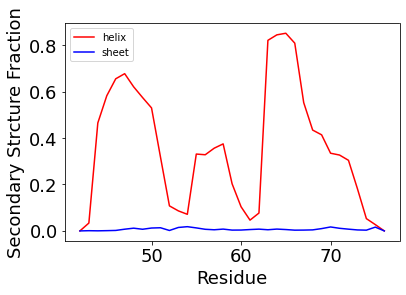

In [ ]:
#dssp=md.compute_dssp(trj,simplified=True)

def dssp_convert(dssp):
 dsspH=np.copy(dssp)
 dsspE=np.copy(dssp)
 dsspH[dsspH=='H']=1                                                                                      
 dsspH[dsspH=='E']=0                                                                                      
 dsspH[dsspH=='C']=0                                                                                      
 dsspH[dsspH=='NA']=0 
 dsspH=dsspH.astype(int)
 TotalH=np.sum(dsspH,axis=1) 
 Hprop=np.sum(dsspH,axis=0).astype(float)/len(dsspE) 

 dsspE[dsspE=='H']=0
 dsspE[dsspE=='E']=1
 dsspE[dsspE=='C']=0
 dsspE[dsspE=='NA']=0
 dsspE=dsspE.astype(int)
 TotalE=np.sum(dsspE,axis=1) 
 Eprop=np.sum(dsspE,axis=0).astype(float)/len(dsspE) 
 return Hprop, Eprop

Hprop,Eprop=dssp_convert(dssp)
plt.plot(resid_xray,Hprop,c='r',label='helix')
plt.plot(resid_xray,Eprop,c='b',label='sheet')

plt.legend(loc="upper left")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.tick_params(labelsize=18)


In [ ]:
indices_phi, phis = md.compute_phi(trj)
indices_psi, psis = md.compute_psi(trj)
indices_chi1, chi1s = md.compute_chi1(trj)
indices_chi2, chi2s = md.compute_chi2(trj)

In [ ]:
phi_dict={}
dihedral_dict = { 'phi': { },
          'psi': { },
          'chi1': { },
          'chi2': { }}

for i in range(0,len(indices_phi)):
  indices=indices_phi[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['phi'][resnum]=phis[:,i]

for i in range(0,len(indices_psi)):
  indices=indices_psi[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['psi'][resnum]=psis[:,i]

for i in range(0,len(indices_chi1)):
  indices=indices_chi1[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['chi1'][resnum]=chi1s[:,i]

for i in range(0,len(indices_chi2)):
  indices=indices_chi2[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['chi2'][resnum]=chi2s[:,i]

In [ ]:
#Heres a function to plot a phi/psi ramachandran plot:

def plot_phipsi(res):
 plt.hist2d(dihedral_dict['phi'][res],dihedral_dict['psi'][res],bins=36,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
 plt.xlabel('$\phi$', size=18)
 plt.ylabel('$\psi$', size=18)
 plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.tick_params(labelsize=18)
 plt.show()
 return

def plot_chi(res):
    if res in dihedral_dict['chi1']:
     plt.hist(dihedral_dict['chi1'][res],bins=36,range=[-3.14,3.14])        
     plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.xlabel('$\chi_1$', size=18)
     plt.ylabel('counts', size=18)
     plt.tick_params(labelsize=18)
     plt.show()
     plt.clf()   
    if res in dihedral_dict['chi2']:
     plt.hist2d(dihedral_dict['chi1'][res],dihedral_dict['chi2'][res],bins=36,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
     plt.xlabel('$\chi_1$', size=18)
     plt.ylabel('$\chi_2$', size=18)
     plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.tick_params(labelsize=18)
     plt.show()
    return




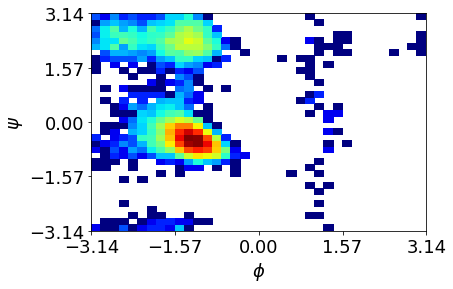

In [ ]:
plot_phipsi(45)


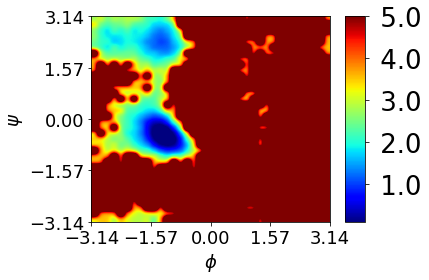

In [ ]:
def plot_phipsi_FES(res):
 free_energy,xedges,yedges=np.histogram2d(dihedral_dict['psi'][res],dihedral_dict['phi'][res],36,[[-3.14,3.14],[-3.14,3.14]],normed=True,weights=None)
 free_energy=np.log(np.flipud(free_energy)+.000001)
 T=300                                                                                                  
 kbT=T*0.008314/4.184 # kT in kcal/mol
 dG=-(kbT)*free_energy #Convert to kcal/mol
 im=plt.imshow(dG, interpolation='gaussian',extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],cmap='jet',aspect='auto')
 cbar_ticks=[0,1,2,3,4,5]
 cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'), aspect=10) # grab the Colorbar instance
 imaxes = plt.gca()                                                                                                 
 plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.xlabel('$\phi$', size=18)
 plt.ylabel('$\psi$', size=18)
 plt.tick_params(labelsize=18)
 plt.axes(cb.ax)
 plt.clim(vmin=0.1,vmax=5.0)
 plt.yticks(size='26')
 plt.tight_layout()
 plt.show()
 return

plot_phipsi_FES(45)

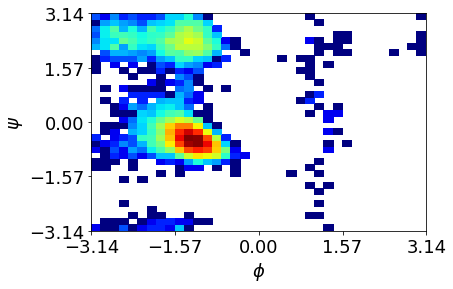

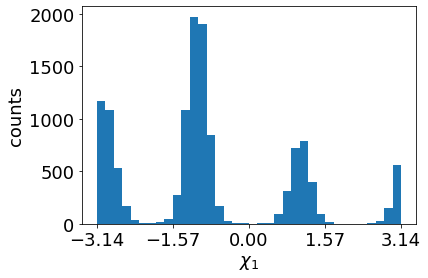

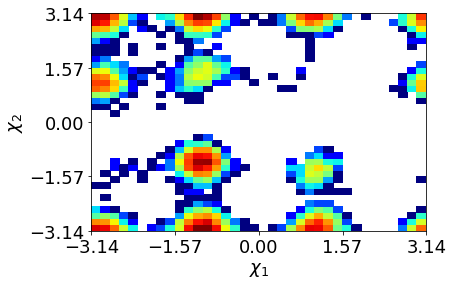

In [ ]:
plot_phipsi(45)
plt.clf()
plot_chi(45)

In [ ]:
xray_CA = md.load_pdb(xray_CA_pdb)
top_xray = xray_CA.topology
top_xray
residue_xray=[]
for res in top.residues: 
    residue_xray.append(res.resSeq)
resid_xray=np.asarray(residue_xray)
resid_xray

array([42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,
       59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75,
       76, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,
       58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74,
       75, 76])

In [ ]:
trjCA = md.load(trajectory, top=pdb,stride=stride_sel)
CA=top.select("name CA")
trjCA.restrict_atoms(CA)
trjCA.center_coordinates()

<mdtraj.Trajectory with 12559 frames, 35 atoms, 35 residues, and unitcells at 0x7fbcce725850>

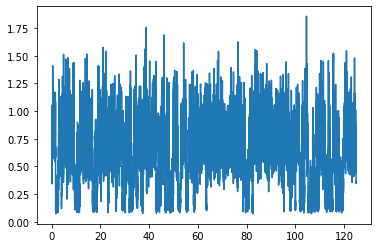

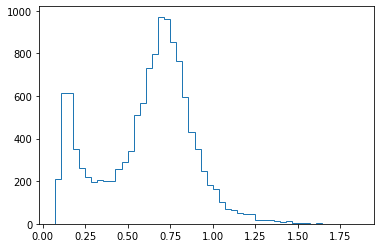

In [ ]:
CA_trj_sel=trj.topology.select("name CA")
CA_xray_sel=xray_CA.topology.select("name CA")
rmsd = md.rmsd(trjCA,xray_CA)
plt.plot(time,rmsd)
plt.show()
plt.clf()

plt.hist(rmsd,histtype='step',bins=50)
plt.show()

In [ ]:
native_frames=np.where(rmsd<0.25)[0]
len(native_frames)


2054

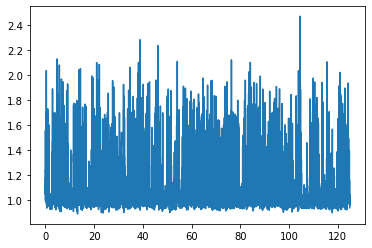

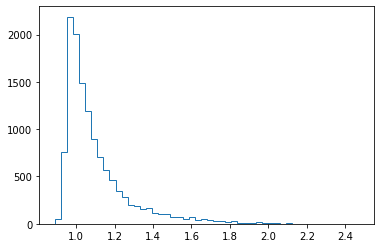

In [ ]:
#Lets calculate the radius of gyration
rg=md.compute_rg(trj, masses=None)
plt.plot(time,rg)
plt.show()
plt.clf()

plt.hist(rg,histtype='step',bins=50)
plt.show()

In [ ]:
import sklearn
from sklearn.decomposition import PCA

pca1 = PCA(n_components=2)
trj.superpose(trj, 0)
reduced_cartesian = pca1.fit_transform(trj.xyz.reshape(trj.n_frames, trj.n_atoms * 3))
print(reduced_cartesian.shape)

(12559, 2)


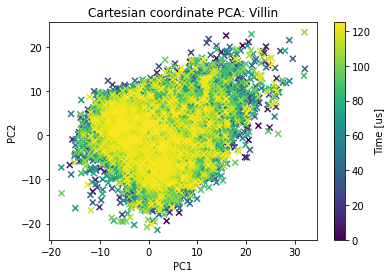

In [ ]:
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=time)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: Villin')
cbar = plt.colorbar()
cbar.set_label('Time [us]')

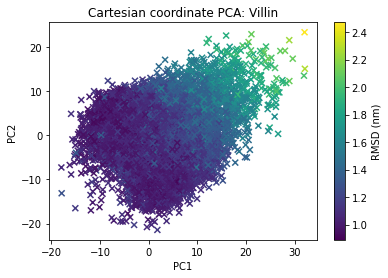

In [ ]:
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=rg)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: Villin')
cbar = plt.colorbar()
cbar.set_label('RMSD (nm)')

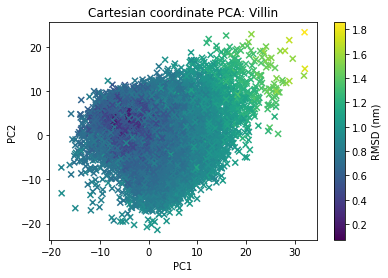

In [ ]:
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=rmsd)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: Villin')
cbar = plt.colorbar()
cbar.set_label('RMSD (nm)')

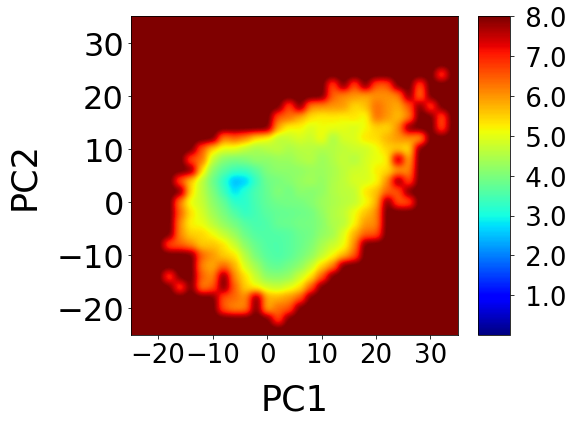

In [ ]:
def free_energy(a, b, T, y0, ymax, x0, xmax):
    free_energy, xedges, yedges = np.histogram2d(
        a, b, 30, [[y0, ymax], [x0, xmax]], normed=True, weights=None)
    free_energy = np.log(np.flipud(free_energy)+.000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xedges, yedges

PC1=reduced_cartesian[:, 0]
PC2=reduced_cartesian[:,1]

dG,xedges,yedges=free_energy(PC2, PC1, 300, -25, 35, -25, 35)

fig = plt.figure(figsize=(8, 6))
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3, 4, 5,6,7,8]
plt.xlim(-25,35)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("PC2", size=35, labelpad=15)
plt.xlabel("PC1", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.01, vmax=8.0)
plt.yticks(size='26')
plt.tight_layout()

*** Classroom Activitiy: Lets plot the free energy as a function of RMSD***

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  """


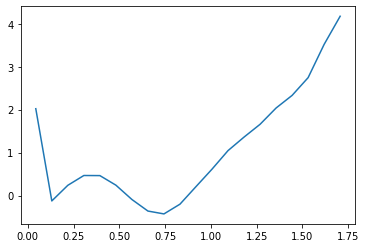

<Figure size 432x288 with 0 Axes>

In [ ]:
#Lets Plot Free Energies as a function of RMSD and Rg

def free_energy1D(a,T,x0,xmax,bins):
    free_energy, xedges= np.histogram(
        a, bins, [x0, xmax], normed=True, weights=None)
    xcenters= xedges[:-1] + np.diff(xedges)/2
    free_energy = np.log(free_energy+.0000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xcenters


dG_RMSD,xedges = free_energy1D(rmsd, 300, 0, 1.75, 20)
dG_RMSD 


plt.plot(xedges, dG_RMSD)
plt.show()
plt.clf()

Possible Homework Prompt 

*** Classroom Activitiy: Lets plot the free energy as a function of Rg vs. RMSD***

In [ ]:
#Visualize the lowerst free energy basin 
basin_frames=np.where((rmsd>.60) & (rmsd<0.80))[0]
len(basin_frames)

#then we could save it and visualize it 


4758

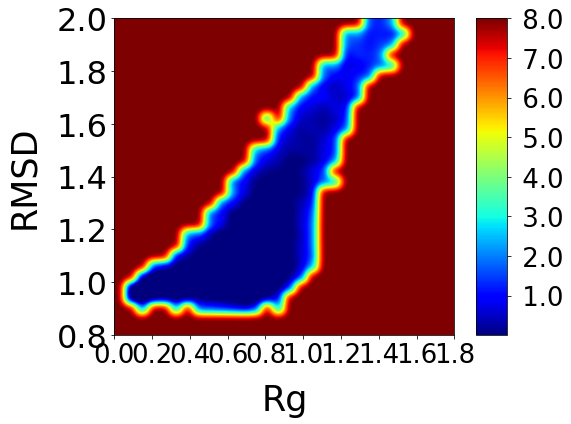

In [ ]:
dG,xedges,yedges=free_energy(rg, rmsd, 300, 0.8, 2.0, 0, 1.8)

fig = plt.figure(figsize=(8, 6))
#im = plt.imshow(dG, extent=[
#                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3, 4, 5,6,7,8]
#plt.xlim(-25,35)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("RMSD", size=35, labelpad=15)
plt.xlabel("Rg", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.01, vmax=8.0)
plt.yticks(size='26')
plt.tight_layout()

In [ ]:
#Lets Make a Contact Map
contact_maps = []
contact_distances = []

for i in range(0, 34):
    contact_map = []
    contact_distance = []
    for j in range(0, 34):
        if i == j:
            contacts = 0
        else:
            dist = md.compute_contacts(trj, [[i, j]])
            array = np.asarray(dist[0]).astype(float)
            distance = np.average(array)
            contact_distance.append(distance)
            contact = np.where(array < 0.5, 1, 0)
            contacts = np.average(contact)
        contact_map.append(contacts)
    contact_maps.append(contact_map)
    contact_distances.append(contact_distance)
final_map = np.asarray(contact_maps).astype(float)
final_distance = np.asarray(contact_distances).astype(float)


In [ ]:
#Lets Make Nice Contact Map Labels
sequence=[]
for residue in trj.topology.residues:
    sequence.append(residue)

#Lets Zero Out some of the Labels 
n=2
for i in range (0,len(sequence)): 
  if (i % n !=0):
   sequence[i]=''

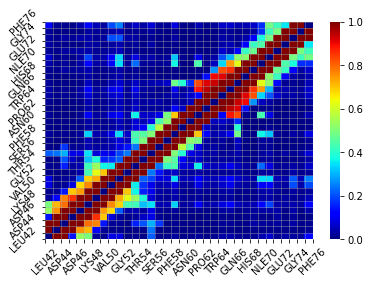

In [ ]:
ax = sns.heatmap(final_map, vmin=0.0, vmax=1.0,cmap='jet')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,35))
ax.set_yticks(range(0,35))
ax.set_xticklabels(sequence[:35],rotation=45)
ax.set_yticklabels(sequence[:35],rotation=45)
plt.show()

In [ ]:
def circular_mean(angle):
    return np.arctan2(np.sum(np.sin(angle)),np.sum(np.cos(angle)))


def circular_corr(angle1,angle2):
    cmean1=circular_mean(angle1)
    cmean2=circular_mean(angle2)
    numerator=(np.sum(np.sin(angle1-cmean1)*np.sin(angle2-cmean2)))
    denom=((np.sum(np.sin(angle1-cmean1)**2)*np.sum(np.sin(angle2-cmean2)**2))**.5)
    ccor=numerator/denom
    return ccor

In [ ]:
# Make correlation contact map
correlation_maps = []
for i in range(43, 76):
    cor_map = []
    for j in range(43, 76):
        phi=dihedral_dict['phi'][i]
        psi=dihedral_dict['psi'][j]
        ccor=circular_corr(psi,phi)
        cor_map.append(ccor)
    correlation_maps.append(cor_map)
final_cor_map = np.asarray(correlation_maps).astype(float)
np.shape(final_map)

(34, 34)

In [ ]:
sequence=[]
for residue in trj.topology.residues:
    sequence.append(residue)
len(sequence)
seq_trunc=sequence[1:34]
#Lets Zero Out some of the Labels 
n=2
for i in range (0,33): 
  if (i % n !=0):
   seq_trunc[i]=''

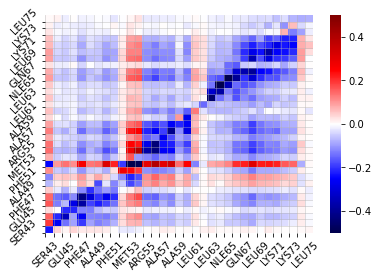

In [ ]:
mask = np.zeros_like(final_map)
zeros=np.where((final_map<0.10) & (final_map>-0.10))
mask[zeros] = True
ax = sns.heatmap(final_cor_map, vmin=-0.5, vmax=0.5,cmap='seismic')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,33))
ax.set_yticks(range(0,33))
ax.set_xticklabels(seq_trunc,rotation=45)
ax.set_yticklabels(seq_trunc,rotation=45)
plt.show()

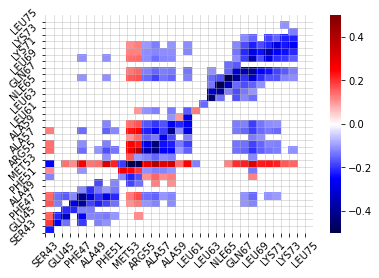

In [ ]:
mask = np.zeros_like(final_cor_map)
zeros=np.where((final_cor_map<0.10) & (final_cor_map>-0.10))
mask[zeros] = True
ax = sns.heatmap(final_cor_map,mask=mask, vmin=-0.5, vmax=0.5,cmap='seismic')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,33))
ax.set_yticks(range(0,33))
ax.set_xticklabels(seq_trunc,rotation=45)
ax.set_yticklabels(seq_trunc,rotation=45)
plt.show()

We want to try to Reproduce the Free Energy Plot From
https://www.science.org/doi/full/10.1126/science.1208351



First we need to determine the native contacts and calculate Q



In [ ]:
#Lets Make a 1D array that contains all native distances pairs:
xray_CA

<mdtraj.Trajectory with 1 frames, 35 atoms, 35 residues, and unitcells at 0x7fbcce7b8b10>

In [ ]:
#Lets Make a 1D array that contains all native distances pairs:
native_distance_matrix1D=[]
#QUESTION: How can you make a 1D Array that only contains distances between residue pairs seperated by more than 7 residuyes

for i in range(0,35):
  for j in range(0,35):
    if (abs(i-j) > 7):
      dist=md.compute_distances(xray_CA, [[i,j]])[0]
      native_distance_matrix1D.append(dist[0])


print(native_distance_matrix1D)



#Convert to Angstrom
native_distance_matrix1D=np.asarray(native_distance_matrix1D)*10


[0.92885566, 1.1002597, 1.3174998, 1.2974675, 1.1456033, 0.99857265, 1.1460043, 1.4596794, 1.3557265, 1.1562319, 1.3011403, 1.6130928, 1.7153845, 1.6867902, 2.0679474, 1.9010408, 1.5606644, 1.6592368, 1.8033708, 1.4887061, 1.2800236, 1.5757791, 1.6287162, 1.2990911, 1.324484, 1.0320789, 1.0402143, 1.197964, 1.3129104, 1.2526512, 1.0452459, 0.9704253, 1.1858181, 1.4817126, 1.4141105, 1.334659, 1.436302, 1.7875955, 1.944044, 1.9661098, 2.3102033, 2.0870423, 1.7597795, 1.9201467, 2.0525544, 1.7176661, 1.5681386, 1.8858025, 1.898656, 1.5687101, 1.6518222, 1.3808665, 1.3982571, 1.0919163, 0.96034896, 0.7096728, 0.70852816, 0.999271, 1.1701868, 1.1763029, 1.3330957, 1.4182544, 1.7105116, 1.951937, 1.9905045, 2.1878319, 1.9377486, 1.637223, 1.8638574, 1.9799309, 1.6400279, 1.5666395, 1.912473, 1.8929143, 1.5985601, 1.7549322, 1.5002321, 1.5272311, 0.95745665, 0.8303897, 0.9653463, 0.9792494, 1.2350922, 1.3557656, 1.2426256, 1.2379509, 1.6166704, 1.8420823, 1.958403, 2.3047237, 2.0577104, 1.79

In [ ]:
len(native_distance_matrix1D)

756

In [ ]:
#Now lets do the same thing for our trajectory, making an array that is contacts vs. #frames in the trajectory
traj_CA_distance_matrix1D=[]


for i in range(0,35):
  for j in range(0,35):
    if (abs(i-j) > 7):
      dist=md.compute_distances(trjCA, [[i,j]])[:,0]
      traj_CA_distance_matrix1D.append(dist)



#Convert to Angstrom
traj_CA_distance_matrix1D=np.asarray(traj_CA_distance_matrix1D)*10

    
np.shape(traj_CA_distance_matrix1D)

(756, 12559)

In [ ]:
#Make Sure that For each Distance you can compare that native distance to the trajectory distance 
print(np.average(traj_CA_distance_matrix1D[1]))

print(np.average(traj_CA_distance_matrix1D[1][native_frames]))

14.991439
12.49849


In [ ]:
print(native_frames)

traj_CA_distance_matrix1D[:,native_frames]
native_average = np.average(traj_CA_distance_matrix1D[:,native_frames], axis=1)
np.shape(native_average)

[  158   159   160 ... 12022 12023 12027]


(756,)

In [ ]:
Native_Contact_Indices=np.where(native_average<10.0)[0]
len(Native_Contact_Indices)

48

In [ ]:
Native_Contacts_Trj_Dist=traj_CA_distance_matrix1D[Native_Contact_Indices]
np.shape(Native_Contacts_Trj_Dist)

Native_Contacts_Xray_Dist=traj_CA_distance_matrix1D[Native_Contact_Indices]
np.shape(Native_Contacts_Xray_Dist)

(48, 12559)

In [ ]:
for i in range(0,48):
  print(Native_Contacts_Xray_Dist[i], Native_Contacts_Trj_Dist[i])

[11.540491 15.242111 20.317595 ... 11.133914  9.802909  9.529006] [11.540491 15.242111 20.317595 ... 11.133914  9.802909  9.529006]
[ 9.374432 15.550833 18.456451 ...  9.84092   8.556069  8.788097] [ 9.374432 15.550833 18.456451 ...  9.84092   8.556069  8.788097]
[11.477718 13.614361 20.877588 ...  8.659006  7.637048  7.693935] [11.477718 13.614361 20.877588 ...  8.659006  7.637048  7.693935]
[ 9.620813  14.315687  13.511494  ...  9.546892   7.7607603  7.720747 ] [ 9.620813  14.315687  13.511494  ...  9.546892   7.7607603  7.720747 ]
[ 8.358078  12.062386  16.181501  ...  6.1711082  5.2470694  5.1262226] [ 8.358078  12.062386  16.181501  ...  6.1711082  5.2470694  5.1262226]
[10.051856  10.599729  18.739012  ...  5.1992693  5.975244   5.3546863] [10.051856  10.599729  18.739012  ...  5.1992693  5.975244   5.3546863]
[13.804028 13.680305 21.581156 ...  7.900141  8.840288  8.60963 ] [13.804028 13.680305 21.581156 ...  7.900141  8.840288  8.60963 ]
[12.595353  16.094152  12.5168705 ...  8

In [ ]:
#Expand Native Distance Matrix so that its the same number of frames as the trajectory
Xray_Distance_Expand=np.zeros(np.shape(Native_Contacts_Trj_Dist))
for i in range(0,len(Native_Contacts_Trj_Dist)):
    Xray_Distance_Expand[i,:]=Native_Contacts_Xray_Dist[i]
    
np.shape(Xray_Distance_Expand)


(48, 12559)

# Compute Q 

In [212]:
#Write a function to Calculate Q 

def cq(xray, traj):
    q = []
    for i in range(len(traj)):
        q.append(np.sum((1/(1+np.exp(10*(traj[i]-(xray+1))))))/len(xray))
    #print(i)
    return q



In [ ]:
# Form Right Shape 
xray = Native_Contacts_Xray_Dist.T
traj = Native_Contacts_Trj_Dist.T

In [218]:
#q = q(trj, trj[0])

# Calculate q 
q = cq(xray, traj)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in exp


12558


In [219]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

q = NormalizeData(q)

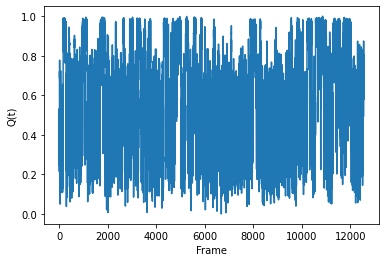

In [220]:
#Plot Q and a Histogram
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(q)
plt.xlabel('Frame', fontsize=10)
plt.ylabel('Q(t)', fontsize=10)
plt.show()

# Histogram of what? 

(array([ 1.,  0.,  0.,  3.,  0.,  0.,  1.,  0.,  1.,  0.,  2.,  0.,  0.,
         0.,  1.,  0.,  2.,  1.,  1.,  3.,  1.,  0.,  0.,  1.,  2.,  2.,
         1.,  3.,  1.,  3.,  4.,  2.,  3.,  1.,  3.,  1.,  1.,  1.,  1.,
         3.,  4.,  4.,  4.,  5.,  4.,  6.,  2.,  5.,  2.,  7.,  6.,  7.,
        10.,  6.,  8.,  3.,  8.,  3.,  6.,  9.,  3.,  3.,  8.,  7.,  4.,
        10.,  6.,  9.,  5.,  6., 10.,  7., 11., 10., 14.,  7.,  9., 12.,
         9., 12.,  5.,  6., 10.,  4., 16., 17., 10., 15.,  9.,  8., 19.,
         9., 15., 10.,  8., 16.,  6., 17., 12., 17., 18., 13., 16., 13.,
        17., 25., 13., 14., 15., 27., 22., 18., 18., 24., 12., 18., 16.,
        17., 16., 19., 23., 15., 23., 26., 17., 29., 20., 26., 25., 23.,
        26., 25., 18., 24., 27., 21., 26., 24., 20., 27., 27., 18., 23.,
        30., 33., 31., 39., 19., 40., 25., 37., 33., 24., 24., 33., 30.,
        27., 33., 27., 42., 31., 34., 29., 32., 36., 35., 44., 34., 48.,
        40., 32., 45., 36., 47., 38., 36., 40., 52.

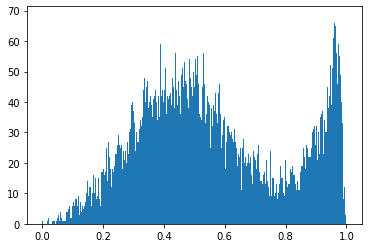

In [221]:
plt.hist(q, bins=500)

# 2D Map 

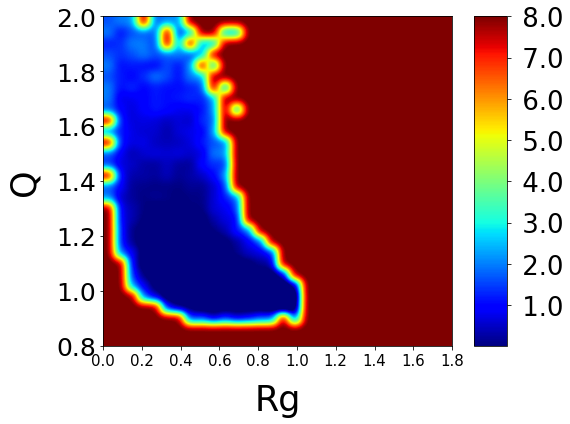

In [244]:
dG,xedges,yedges=free_energy(rg, q, 300, 0.8, 2.0, 0, 1.8)

fig = plt.figure(figsize=(8, 6))
#im = plt.imshow(dG, extent=[
#                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3, 4, 5,6,7,8]
#plt.xlim(-25,35)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("Q", size=35, labelpad=15)
plt.xlabel("Rg", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='15')
plt.yticks(size='25')
plt.axes(cb.ax)
plt.clim(vmin=0.01, vmax=8.0)
plt.yticks(size='26')
plt.tight_layout()

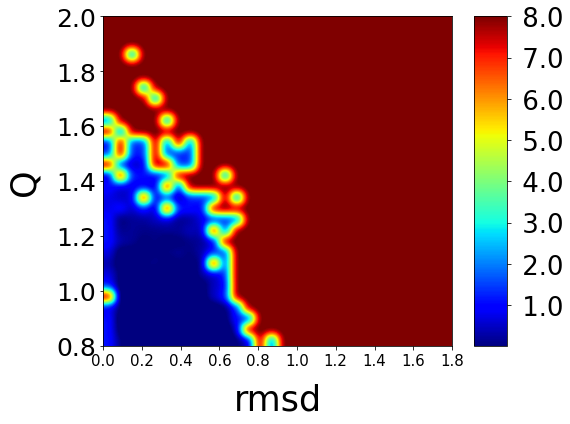

In [243]:
dG,xedges,yedges=free_energy(rmsd, q, 300, 0.8, 2.0, 0, 1.8)

fig = plt.figure(figsize=(8, 6))
#im = plt.imshow(dG, extent=[
#                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3, 4, 5,6,7,8]
#plt.xlim(-25,35)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("Q", size=35, labelpad=15)
plt.xlabel("rmsd", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='15')
plt.yticks(size='25')
plt.axes(cb.ax)
plt.clim(vmin=0.01, vmax=8.0)
plt.yticks(size='26')
plt.tight_layout()

# Identify Transition Paths 

In [226]:
# With Q do the following
#It's stated in the slack - just get two lines. 

# Cut-off used: 0.3 and 0.8
states = []

for frame in q: 

  if frame <=.5: 
    states.append(0)
  elif frame <.75:
    states.append(1)
  else: 
    states.append(2)


rs = states[::-1]


transition = []
for i in range(len(states)):
    if (states[i] == 0 and rs[i] == 2) or (states[i] == 2 and rs[i] == 0):
        transition.append(1)
    else:
        transition.append(0)
        
print('transition:', str(np.sum(transition)))     



transition: 3014


In [227]:
# instantiate
i_fold, i_trans, i_unfold = ([], [], [])

for i in range(len(q)):
    if q[i] <= 0.5:
        i_unfold.append(i)
    elif q[i] < 0.75:
        i_trans.append(i)
    else:
        i_fold.append(i)

fold = trj[i_fold]
transition = trj[i_trans]
unfold = trj[i_unfold]

# Contact Map: Fold

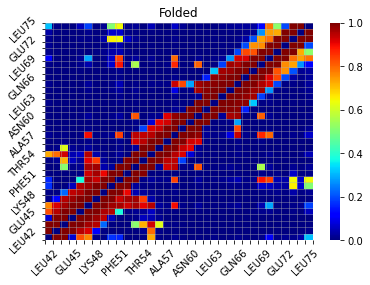

In [228]:
contact_maps = []
contact_distances = []

for i in range(0, 34):
    contact_map = []
    contact_distance = []
    for j in range(0, 34):
        if i == j:
            contacts = 0
        else:
            dist = md.compute_contacts(fold, [[i, j]])
            array = np.asarray(dist[0]).astype(float)
            distance = np.average(array)
            contact_distance.append(distance)
            contact = np.where(array < 0.5, 1, 0)
            contacts = np.average(contact)
        contact_map.append(contacts)
    contact_maps.append(contact_map)
    contact_distances.append(contact_distance)
final_map = np.asarray(contact_maps).astype(float)
final_distance = np.asarray(contact_distances).astype(float)

# Lets Make Nice Contact Map Labels
sequence = []
for residue in trj.topology.residues:
    sequence.append(residue)

# Lets Zero Out some of the Labels
n = 3
for i in range(0, len(sequence)):
    if (i % n != 0):
        sequence[i] = ''

# Make Map
ax = sns.heatmap(final_map, vmin=0.0, vmax=1.0, cmap='jet')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0, 35))
ax.set_yticks(range(0, 35))
ax.set_xticklabels(sequence[:35], rotation=45)
ax.set_yticklabels(sequence[:35], rotation=45)
ax.set_title("Folded")
plt.show()

Contact Map: Transition

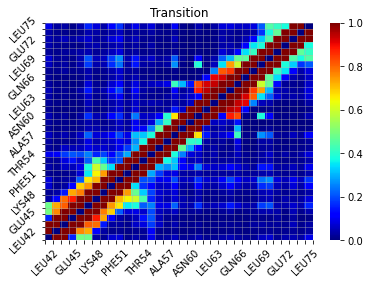

In [229]:
contact_maps = []
contact_distances = []

for i in range(0, 34):
    contact_map = []
    contact_distance = []
    for j in range(0, 34):
        if i == j:
            contacts = 0
        else:
            dist = md.compute_contacts(transition, [[i, j]])
            array = np.asarray(dist[0]).astype(float)
            distance = np.average(array)
            contact_distance.append(distance)
            contact = np.where(array < 0.5, 1, 0)
            contacts = np.average(contact)
        contact_map.append(contacts)
    contact_maps.append(contact_map)
    contact_distances.append(contact_distance)
final_map = np.asarray(contact_maps).astype(float)
final_distance = np.asarray(contact_distances).astype(float)

# Lets Make Nice Contact Map Labels
sequence = []
for residue in trj.topology.residues:
    sequence.append(residue)

# Lets Zero Out some of the Labels
n = 3
for i in range(0, len(sequence)):
    if (i % n != 0):
        sequence[i] = ''

# Make Map
ax = sns.heatmap(final_map, vmin=0.0, vmax=1.0, cmap='jet')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0, 35))
ax.set_yticks(range(0, 35))
ax.set_xticklabels(sequence[:35], rotation=45)
ax.set_yticklabels(sequence[:35], rotation=45)
ax.set_title("Transition")
plt.show()

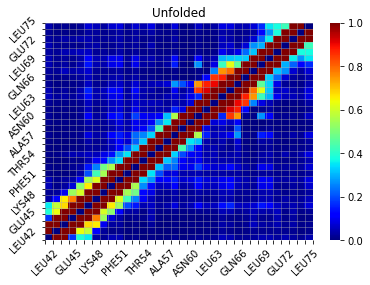

In [230]:
contact_maps = []
contact_distances = []

for i in range(0, 34):
    contact_map = []
    contact_distance = []
    for j in range(0, 34):
        if i == j:
            contacts = 0
        else:
            dist = md.compute_contacts(unfold, [[i, j]])
            array = np.asarray(dist[0]).astype(float)
            distance = np.average(array)
            contact_distance.append(distance)
            contact = np.where(array < 0.5, 1, 0)
            contacts = np.average(contact)
        contact_map.append(contacts)
    contact_maps.append(contact_map)
    contact_distances.append(contact_distance)
final_map = np.asarray(contact_maps).astype(float)
final_distance = np.asarray(contact_distances).astype(float)

# Lets Make Nice Contact Map Labels
sequence = []
for residue in trj.topology.residues:
    sequence.append(residue)

# Lets Zero Out some of the Labels
n = 3
for i in range(0, len(sequence)):
    if (i % n != 0):
        sequence[i] = ''

# Make Map
ax = sns.heatmap(final_map, vmin=0.0, vmax=1.0, cmap='jet')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0, 35))
ax.set_yticks(range(0, 35))
ax.set_xticklabels(sequence[:35], rotation=45)
ax.set_yticklabels(sequence[:35], rotation=45)
ax.set_title("Unfolded")
plt.show()

# Correlation

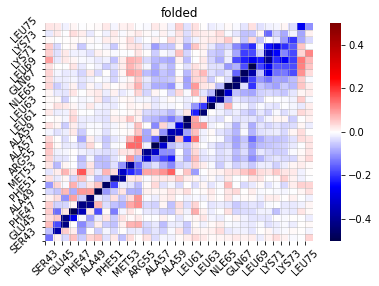

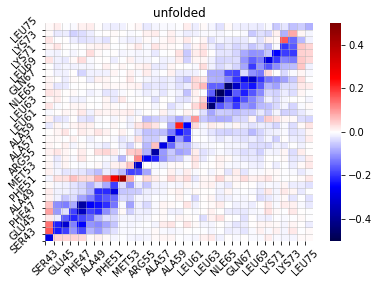

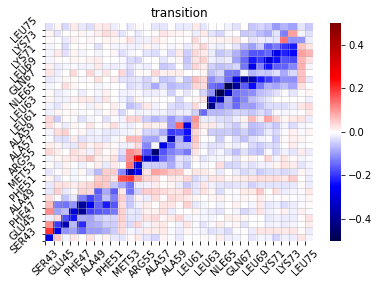

<Figure size 432x288 with 0 Axes>

In [259]:
for element in li:
  name, traj = element

  indices_phi, phis = md.compute_phi(traj)
  indices_psi, psis = md.compute_psi(traj)
  indices_chi1, chi1s = md.compute_chi1(traj)
  indices_chi2, chi2s = md.compute_chi2(traj)

  phi_dict={}
  dihedral_dict = { 'phi': { },
            'psi': { },
            'chi1': { },
            'chi2': { }}

  for i in range(0,len(indices_phi)):
    indices=indices_phi[i]
    atom=top.atom(indices[1])
    resnum=top.atom(indices[1]).residue.resSeq
    dihedral_dict['phi'][resnum]=phis[:,i]

  for i in range(0,len(indices_psi)):
    indices=indices_psi[i]
    atom=top.atom(indices[1])
    resnum=top.atom(indices[1]).residue.resSeq
    dihedral_dict['psi'][resnum]=psis[:,i]

  for i in range(0,len(indices_chi1)):
    indices=indices_chi1[i]
    atom=top.atom(indices[1])
    resnum=top.atom(indices[1]).residue.resSeq
    dihedral_dict['chi1'][resnum]=chi1s[:,i]

  for i in range(0,len(indices_chi2)):
    indices=indices_chi2[i]
    atom=top.atom(indices[1])
    resnum=top.atom(indices[1]).residue.resSeq
    dihedral_dict['chi2'][resnum]=chi2s[:,i]


  correlation_maps = []
  for i in range(43, 76):
      cor_map = []
      for j in range(43, 76):
          phi = dihedral_dict['phi'][i]
          psi = dihedral_dict['psi'][j]
          ccor = circular_corr(psi, phi)
          cor_map.append(ccor)
      correlation_maps.append(cor_map)
  final_cor_map = np.asarray(correlation_maps).astype(float)

  mask = np.zeros_like(final_map)
  zeros = np.where((final_map < 0.10) & (final_map > -0.10))
  mask[zeros] = True
  ax = sns.heatmap(final_cor_map, vmin=-0.5, vmax=0.5, cmap='seismic')
  ax.invert_yaxis()
  ax.grid(which='both', alpha=0.5)
  ax.set_xticks(range(0, 33))
  ax.set_yticks(range(0, 33))
  ax.set_xticklabels(seq_trunc, rotation=45)
  ax.set_yticklabels(seq_trunc, rotation=45)
  ax.set_title(name)
  plt.show()
  plt.clf()

#States 

In [248]:
def dssp_convert(dssp):
 dsspH=np.copy(dssp)
 dsspE=np.copy(dssp)
 dsspH[dsspH=='H']=1                                                                                      
 dsspH[dsspH=='E']=0                                                                                      
 dsspH[dsspH=='C']=0                                                                                      
 dsspH[dsspH=='NA']=0 
 dsspH=dsspH.astype(int)
 TotalH=np.sum(dsspH,axis=1) 
 Hprop=np.sum(dsspH,axis=0).astype(float)/len(dsspE) 

 dsspE[dsspE=='H']=0
 dsspE[dsspE=='E']=1
 dsspE[dsspE=='C']=0
 dsspE[dsspE=='NA']=0
 dsspE=dsspE.astype(int)
 TotalE=np.sum(dsspE,axis=1) 
 Eprop=np.sum(dsspE,axis=0).astype(float)/len(dsspE) 
 return Hprop, Eprop

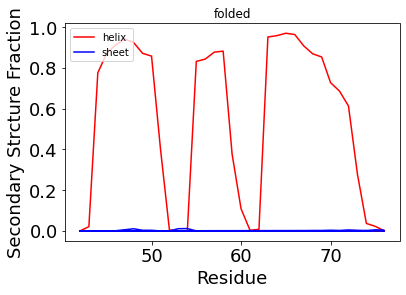

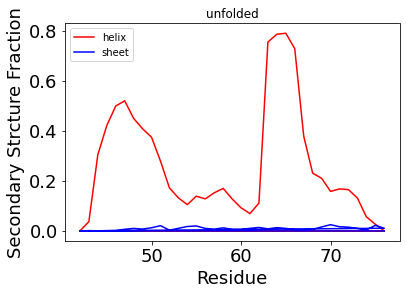

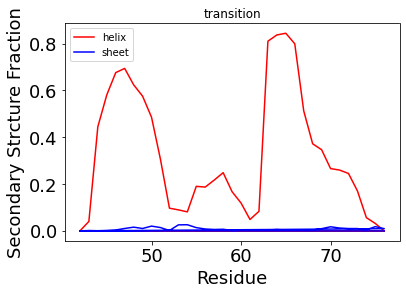

<Figure size 432x288 with 0 Axes>

In [252]:
# fold
li = [("folded",fold), ("unfolded", unfold), ("transition",transition)]
for element in li: 
  name, traj = element
  dssp=md.compute_dssp(traj,simplified=True)
  Hprop,Eprop=dssp_convert(dssp)
  plt.plot(residue_num,Hprop,c='r',label='helix')
  plt.plot(residue_num,Eprop,c='b',label='sheet')

  plt.title(name)
  plt.legend(loc="upper left")
  plt.xlabel('Residue', size=18)
  plt.ylabel('Secondary Strcture Fraction', size=18)
  plt.tick_params(labelsize=18)
  plt.show()
  plt.clf()


#My Question: What would all of the states look like?

In [254]:
def dssp_convert_type(dssp,type):
 dsspS=np.copy(dssp)
 dsspS[dsspS!=type]=0                                                                                      
 dsspS[dsspS==type]=1                                                                                      
 dsspS=dsspS.astype(int)
 TotalS=np.sum(dsspS,axis=1) 
 Sprop=np.sum(dsspS,axis=0).astype(float)/len(dsspS) 
 return Sprop


SS: H [63 64 65 66]
SS: E []
SS: I []
SS: G []
SS: B []
SS: T []
SS: S [61]
SS:   [42 43 54 62 75 76]


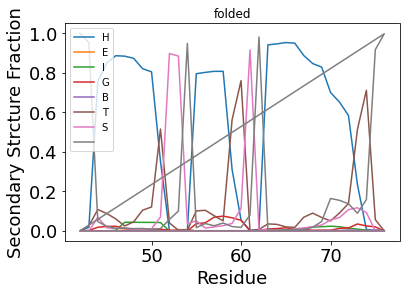

SS: H []
SS: E []
SS: I []
SS: G []
SS: B []
SS: T []
SS: S []
SS:   [42 43 76]


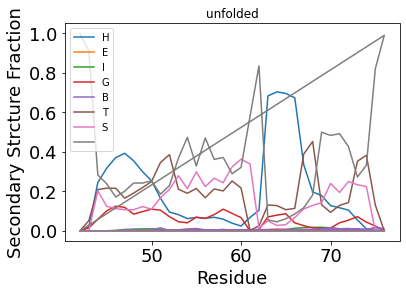

SS: H []
SS: E []
SS: I []
SS: G []
SS: B []
SS: T []
SS: S []
SS:   [42 43 76]


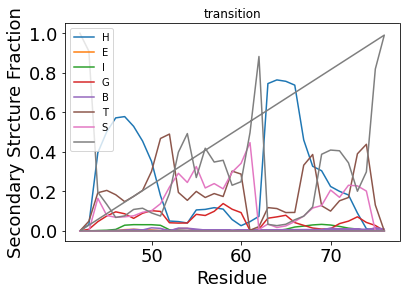

<Figure size 432x288 with 0 Axes>

In [256]:

for element in li: 
  name, traj = element
  dssp_full=md.compute_dssp(traj,simplified=False)
  for t in ['H','E','I','G','B','T','S',' ']:
    Tprop=dssp_convert_type(dssp_full,t)
    plt.plot(residue_num,Tprop,label=t)
    print("SS:",t,np.asarray(residue_num)[np.where(Tprop>.90)])

  plt.title(name)
  plt.legend(loc="upper left")
  plt.xlabel('Residue', size=18)
  plt.ylabel('Secondary Strcture Fraction', size=18)
  plt.tick_params(labelsize=18)
  plt.show()
  plt.clf()

ABOVE 

In [231]:
#Now Lets Filter Our Distances based on only the "Native Portion of the Trajectory" and recompute Q
native_frames 

array([  158,   159,   160, ..., 12022, 12023, 12027])

In [232]:
#Select Only the Frames with low RMSD from native state for the native distances


In [233]:
#Filter the native distances to only include distances where the average value < 10A in the native frames 


In [234]:
#Check that we're comparing all the correct distances 


In [235]:
#Plot Q using only our native frames


In [236]:
#Lets Calculate Our Transition Paths using the Dual Cutoff Approach 

In [237]:
#Consider using a windowing function to smooth our vlaues of Q for Transition Path Calculations
